In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, Tuple, List, Callable

import os
import cv2

In [2]:
files=[]
for root, dirs, in_files in os.walk("Sample"):
    for f in in_files:
        files.append(os.path.join(root, f))
gray_image0 = cv2.imread(files[0], cv2.IMREAD_UNCHANGED)
gray_image1 = cv2.imread(files[1], cv2.IMREAD_UNCHANGED)
gray_image2 = cv2.imread(files[2], cv2.IMREAD_UNCHANGED)
gray_image0.shape, gray_image1.shape, gray_image2.shape

((4584, 6441), (4597, 6393), (4280, 5916))

In [3]:
def create_test_pattern(height=100, width=150):
    """Create a test binary image with multiple regions"""
    image = np.ones((height, width))
    
    # Add left block with two rectangles
    image[10:30, 20:50] = 0
    image[40:60, 15:45] = 0
    
    # Add right block with a cross pattern
    image[15:45, 90:100] = 0  # Vertical bar
    image[25:35, 80:110] = 0  # Horizontal bar
    
    # Add small noise-like patterns
    image[70:75, 30:35] = 0
    image[72:77, 33:38] = 0
    image[68:73, 35:40] = 0
    
    # Add bottom right pattern
    image[65:85, 100:120] = 0
    
    # Add some random noise (very sparse)
    rng   = np.random.default_rng(42)
    noise = rng.random(image.shape) > 0.99
    image = 255*np.logical_xor(image, noise).astype(float)
    
    return image

In [4]:
def sum_ratio_criterion(sums: np.ndarray, split_pos: int) -> float:
    """Compute ratio criterion based on sum of pixel values"""
    left_sum  = np.sum(sums[:split_pos])
    right_sum = np.sum(sums[split_pos:])
    return max(left_sum, right_sum) / (min(left_sum, right_sum) + 1e-10)

def black_pixels_ratio_criterion(sums: np.ndarray, split_pos: int, threshold: float = 0.5) -> float:
    """Compute ratio criterion based on proportion of black pixels"""
    # Convert sums to binary (assuming values above threshold are black)
    binary_sums = sums > threshold * np.max(sums)
    
    left_count  = np.sum(binary_sums[:split_pos])
    right_count = np.sum(binary_sums[split_pos:])
    
    # Normalize by length to get proportions
    left_prop = left_count / len(binary_sums[:split_pos]) if split_pos > 0 else 0
    right_prop = right_count / len(binary_sums[split_pos:]) if split_pos < len(binary_sums) else 0
    
    return max(left_prop, right_prop) / (min(left_prop, right_prop) + 1e-10)


In [5]:
@dataclass
class Node:
    """
    Tree node representing an image region and its split
    Args:
       image: A binary image
       bbox: Bounding box in original image coordinates
    """
    image: np.ndarray
    bbox:  Tuple[slice, slice]  # Bounding box in original image coordinates
    split_pos: int = -1
    direction: Optional[str] = None
    ratio: float = 0
    left:  Optional['Node'] = None
    right: Optional['Node'] = None
    
    def __eq__(self, other):
        if not isinstance(other, Node):
            return False
        return (self.bbox == other.bbox and 
                self.split_pos == other.split_pos and 
                self.direction == other.direction)
    
    def __hash__(self):
        return hash((self.bbox, self.split_pos, self.direction))
    
    @property
    def is_leaf(self):
        return self.left is None and self.right is None

In [8]:
class ImageSplitter:
    def __init__(self, image: np.ndarray, max_splits: int = 5, margin: int = 5, 
                 min_ratio: float = 2.0, overall_threshold: float = 0.1,
                 criteria: Callable = black_pixels_ratio_criterion):
        """Initialize the splitter with an image and parameters"""
        self.image      = image
        self.max_splits = max_splits
        self.margin     = margin
        self.min_ratio  = min_ratio
        self.overall_threshold = overall_threshold
        self.root_node  = None
        self.criteria   = criteria

    def _find_best_split(self, image: np.ndarray) -> Tuple[int, Optional[str], float]:
        """Find the best split position and direction"""
        row_sums = np.sum(image, axis=1)
        col_sums = np.sum(image, axis=0)
        
        def try_split(sums, margin):
            n = len(sums)
            max_possible = max(sums) if len(sums) > 0 else 0
            
            if np.mean(sums) < self.overall_threshold * max_possible:
                return -1, 0
                
            valid_range = slice(margin, n - margin)
            valid_sums  = sums[valid_range]
            
            if len(valid_sums) <= 0:
                return -1, 0
            
            min_sum_idx = np.argmin(valid_sums)
            min_value   = np.min(valid_sums)
            max_value   = np.max(valid_sums)
            
            ratio = min_value/n
            #ratio = max_value / (min_value+1e-10) #if min_value != 0 else float('inf')
    
            #left_sum  = np.sum(sums[:split_pos])
            #right_sum = np.sum(sums[split_pos:])
            #ratio = max(left_sum, right_sum) / (min(left_sum, right_sum) + 1e-10)
            
            split_pos   = min_sum_idx + margin
            return (split_pos, ratio) if ratio >= self.min_ratio else (-1, ratio)
        
        v_split_pos, v_ratio = try_split(col_sums, self.margin)
        h_split_pos, h_ratio = try_split(row_sums, self.margin)
        
        if v_ratio < h_ratio and v_split_pos != -1:
            return v_split_pos, 'vertical', v_ratio
        elif h_split_pos != -1:
            return h_split_pos, 'horizontal', h_ratio
        else:
            return -1, None, min(v_ratio, h_ratio)

    def _count_splits(self, node: Optional[Node]) -> int:
        """Count the number of splits in the tree"""
        if node is None or node.is_leaf:
            return 0
        return 1 + self._count_splits(node.left) + self._count_splits(node.right)

    def _count_regions(self, node: Optional[Node]) -> int:
        """Count the number of regions (leaf nodes)"""
        if node is None:
            return 0
        if node.is_leaf:
            return 1
        return self._count_regions(node.left) + self._count_regions(node.right)

    def split(self) -> Node:
        """Perform the iterative splitting of the image"""
        height, width = self.image.shape
        initial_bbox  = (slice(0, height), slice(0, width))
        # Create root node and initialize leaf_nodes array -> the root at the beginning
        self.root_node = Node(image=self.image, bbox=initial_bbox)
        leaf_nodes     = [self.root_node]
        
        for _ in range(self.max_splits):
            best_node       = None
            best_ratio      = 10e+20 #self.min_ratio
            best_split_info = None
            
            # Find the leaf node with the best split ratio
            for node in leaf_nodes[:]:
                if not node.is_leaf:
                    continue
                    
                split_pos, direction, ratio = self._find_best_split(node.image)
                if split_pos != -1 and ratio < best_ratio:
                    best_node       = node
                    best_ratio      = ratio
                    best_split_info = (split_pos, direction)
            
            if best_node is None:
                break
                
            # Apply the best split
            split_pos, direction = best_split_info
            best_node.split_pos  = split_pos
            best_node.direction  = direction
            best_node.ratio      = best_ratio
            
            # Split the image and create child nodes
            if direction == 'vertical':
                left_img  = best_node.image[:, :split_pos]
                right_img = best_node.image[:, split_pos:]
                left_bbox = (best_node.bbox[0], 
                            slice(best_node.bbox[1].start, 
                                  best_node.bbox[1].start + split_pos))
                right_bbox = (best_node.bbox[0], 
                             slice(best_node.bbox[1].start + split_pos, 
                                   best_node.bbox[1].stop))
            else:  # horizontal
                left_img  = best_node.image[:split_pos, :]
                right_img = best_node.image[split_pos:, :]
                left_bbox = (slice(best_node.bbox[0].start, 
                                  best_node.bbox[0].start + split_pos), 
                            best_node.bbox[1])
                right_bbox = (slice(best_node.bbox[0].start + split_pos, 
                                  best_node.bbox[0].stop), 
                            best_node.bbox[1])
            
            best_node.left  = Node(image=left_img, bbox=left_bbox)
            best_node.right = Node(image=right_img, bbox=right_bbox)
            
            leaf_nodes.remove(best_node)
            leaf_nodes.extend([best_node.left, best_node.right])
        
        return self.root_node

    def visualize(self, figsize=(15, 5)):
        """Visualize both the split image and the tree structure"""
        if self.root_node is None:
            raise ValueError("Must call split() before visualization")
        
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        
        # Plot split image
        self._plot_split_image(ax1)
        
        # Plot tree structure
        self._plot_tree_structure(ax2)
        
        plt.tight_layout()
        plt.show()

    def _plot_split_image(self, ax):
        """Plot the image with splits"""
        ax.imshow(self.image, cmap='gray')
        
        def draw_splits(node, color_depth=0):
            if node is None or node.is_leaf:
                return
                
            colors = ['red', 'blue', 'green', 'yellow', 'purple']
            color = colors[color_depth % len(colors)]
            
            y_start, y_end = node.bbox[0].start, node.bbox[0].stop
            x_start, x_end = node.bbox[1].start, node.bbox[1].stop
            
            if node.direction == 'vertical':
                x = x_start + node.split_pos
                ax.plot([x, x], [y_start, y_end], color=color, 
                        linestyle='--', label=f'Split {color_depth+1}')
            else:  # horizontal
                y = y_start + node.split_pos
                ax.plot([x_start, x_end], [y, y], color=color, 
                        linestyle='--', label=f'Split {color_depth+1}')
            
            draw_splits(node.left, color_depth + 1)
            draw_splits(node.right, color_depth + 1)
        
        draw_splits(self.root_node)
        n_splits = self._count_splits(self.root_node)
        n_regions = self._count_regions(self.root_node)
        ax.set_title(f'Split Image ({n_splits} splits, {n_regions} regions)')
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        #ax.legend(by_label.values(), by_label.keys())

    def _plot_tree_structure(self, ax):
        """Plot the tree structure with proper spacing at all levels"""
        ax.clear()
        ax.set_title('Tree Structure')
        ax.axis('off')
    
        def get_leaves_count(node):
            """Count number of leaves under this node"""
            if node is None:
                return 0
            if node.is_leaf:
                return 1
            return get_leaves_count(node.left) + get_leaves_count(node.right)

        def get_tree_depth(node):
            """Get maximum depth of the tree"""
            if node is None or node.is_leaf:
                return 0
            return 1 + max(get_tree_depth(node.left), get_tree_depth(node.right))

        def assign_positions(node, depth=0, pos=0, min_spacing=1.0):
            """Assign x,y positions to all nodes"""
            if node is None:
                return {}
        
            positions = {}
        
            if node.is_leaf:
                positions[node] = (pos, depth)
                return positions
        
            # Calculate positions for left and right subtrees
            left_leaves = get_leaves_count(node.left)
            right_leaves = get_leaves_count(node.right)
            total_leaves = left_leaves + right_leaves
        
            # Calculate spacing based on number of leaves
            spacing = min_spacing * (2 ** (depth))
        
            # Position current node centered above its children
            left_pos = pos - (spacing * (right_leaves) / total_leaves if total_leaves > 0 else spacing/2)
            right_pos = pos + (spacing * (left_leaves) / total_leaves if total_leaves > 0 else spacing/2)
        
            positions[node] = (pos, depth)
        
            # Recursively position children
            positions.update(assign_positions(node.left, depth + 1, left_pos, min_spacing))
            positions.update(assign_positions(node.right, depth + 1, right_pos, min_spacing))
        
            return positions

        # Get node positions
        positions = assign_positions(self.root_node)
    
        # Plot nodes and connections
        for node, (x, y) in positions.items():
            # Node appearance
            node_size = 1000
            text_size = 8
        
            # Node color and text
            if node.is_leaf:
                color = 'lightgreen'
                text = 'Leaf'
            else:
                color = 'lightblue' if node.direction == 'horizontal' else 'lightcoral'
                text = f'{node.direction}\n{node.ratio:.2f}'
        
            # Plot node
            ax.scatter(x, -y, s=node_size, c=color, zorder=2)
            ax.text(x, -y, text, ha='center', va='center', fontsize=text_size)
        
            # Draw connections to children
            if not node.is_leaf:
                left_x, left_y = positions[node.left]
                right_x, right_y = positions[node.right]
                ax.plot([x, left_x], [-y, -left_y], 'k-', zorder=1)
                ax.plot([x, right_x], [-y, -right_y], 'k-', zorder=1)
    
        # Set limits with padding
        xs = [x for x, y in positions.values()]
        ys = [y for x, y in positions.values()]
        max_depth = max(ys)
    
        padding = 0.5
        ax.set_xlim(min(xs) - padding, max(xs) + padding)
        ax.set_ylim(-(max_depth + padding), padding)
        

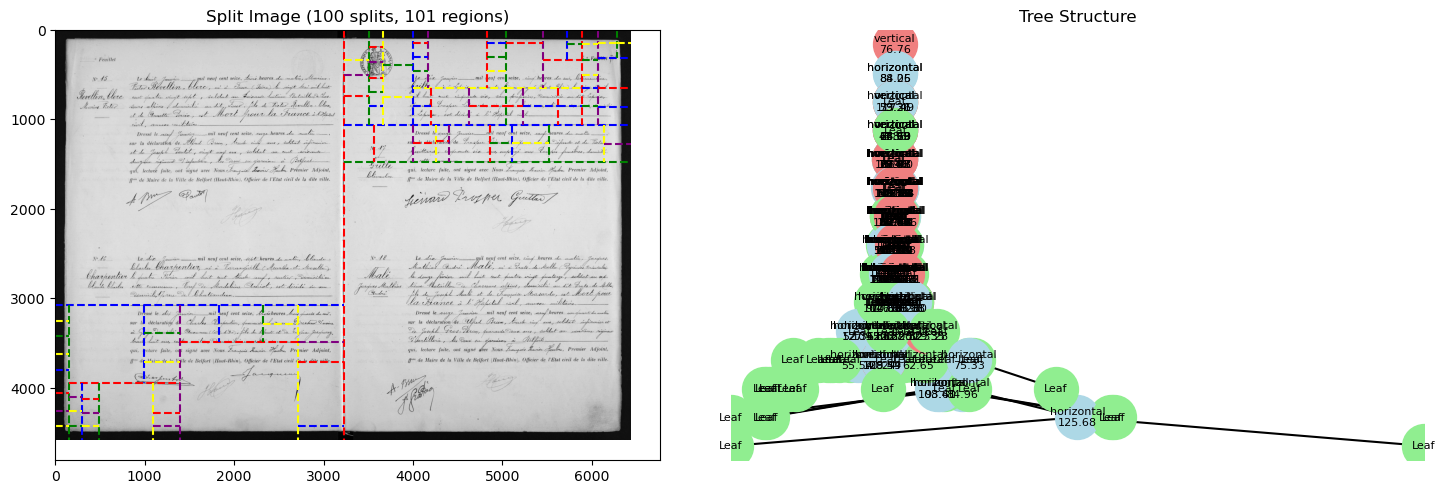

In [9]:
# Create test image
#image = create_test_pattern(height=100, width=150)
#image= gray_image[500:1000, 1000:2150]
# Create splitter instance
splitter = ImageSplitter(gray_image0, max_splits=100, margin=150, min_ratio=-1)

# Perform splitting
splitter.split()

# Visualize results
splitter.visualize()